In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)


# Lectura de bases de datos

In [3]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos = build_features.add_year_month_day(df_diagnosticos, "fecha_atencion")
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion")

In [4]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos = build_features.formatear_fechas_procedimientos(df_procedimientos)
df_procedimientos = build_features.add_year_month_day(df_procedimientos, "fecha_realizacion")
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")

fecha_minimo_procedimientos = min(df_procedimientos.fecha_realizacion)
fecha_maximo_procedimientos = max(df_procedimientos.fecha_realizacion)

## Analisis de cantidad de consultas y procedimientos

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03
El rango de fechas de procedimientos es entre 2020-01-01 00:00:00 y  2022-08-31 00:00:00


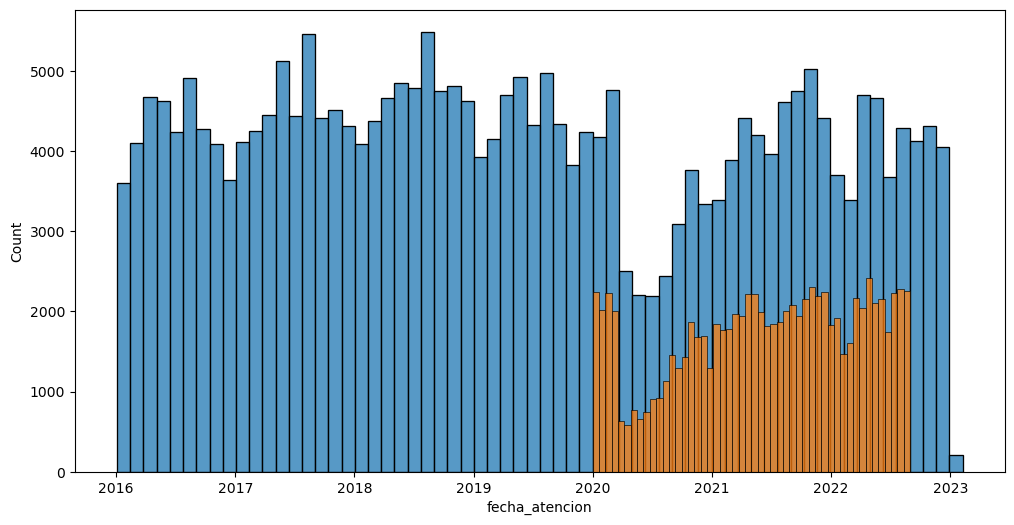

In [5]:
print(
    f"El rango de fechas de diagnosticos es entre {min(df_diagnosticos.fecha_atencion)} y "
    f" {max(df_diagnosticos.fecha_atencion)}"
)
print(
    f"El rango de fechas de procedimientos es entre {fecha_minimo_procedimientos} y "
    f" {fecha_maximo_procedimientos}"
)

sns.histplot(df_diagnosticos["fecha_atencion"])
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()

- Por lo tanto, ambas bases deben estar con el mismo rango temporal. Se procedera a filtrar
la base de diagnosticos

In [6]:
mask_fechas = (df_diagnosticos["fecha_atencion"] >= fecha_minimo_procedimientos) & (
    df_diagnosticos["fecha_atencion"] <= fecha_maximo_procedimientos
)

df_diagnosticos_acotado = df_diagnosticos[mask_fechas]

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 87988 procedimientos


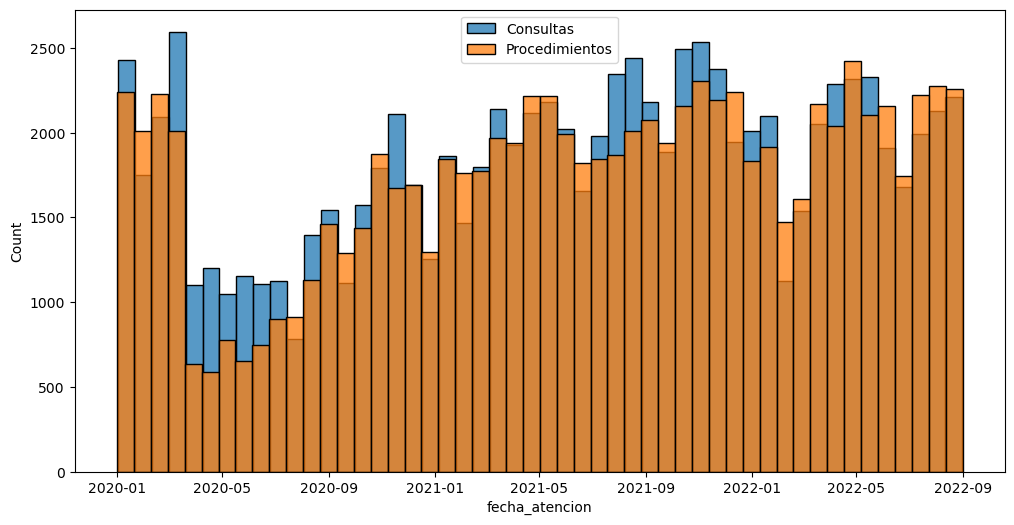

In [7]:
print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

sns.histplot(df_diagnosticos_acotado["fecha_atencion"], label="Consultas")
sns.histplot(df_procedimientos["fecha_realizacion"], label="Procedimientos")
plt.legend()
plt.show()

- Luego, se eliminaran todos los registros que carezcan de una fecha de consulta o procedimientos

In [8]:
df_diagnosticos_acotado = df_diagnosticos_acotado.dropna(subset="fecha_atencion")
df_procedimientos = df_procedimientos.dropna(subset="fecha_realizacion")

print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 87955 procedimientos


- Por lo tanto, la base de consultas carecia de fechas de atencion faltantes. Sin embargo, la
base de procedimientos presentaba 33 fechas faltantes.

# Analisis a lo largo del tiempo

En este analisis se quieren obtener los siguientes insights:

- Frecuencia de diagnosticos por anio
- Rango etario por anio
- Procedencias por anio
- Sexo por anio

In [9]:
desglose_sociodemografico = ["ano"]

variables_a_analizar = ["codigo_diagnostico", "sexo", "rango_etario_primera_consulta"]


In [10]:
resultados_sociodemo = build_features.obtener_dfs_para_desglose_sociodemografico(
    df_diagnosticos, desglose_sociodemografico, variables_a_analizar, "codigo_diagnostico"
)

In [11]:
with pd.ExcelWriter("../data/processed/tableros_powerbi/distribucion_sociodemografica.xlsx") as file:
    for nombre_hoja, df_a_guardar in resultados_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

# Analisis de procedimientos y diagnosticos

- En este apartado se quiere realizar un analisis de cuales procedimientos se le realizan a cada
diagnostico en ambulatorios. La primera forma de resolverlo es de la siguiente forma:

## 1. Union de procedimientos que se hayan realizado dentro de la misma consulta

- Se enlaza por el ID del paciente y la fecha de realizacion de la consulta/procedimiento. Esto
asume que dentro de la consulta se realizo un procedimiento. Por ejemplo: Paciente X con fecha 
de consulta el 21-07-2022 y fecha de procedimiento el 21-07-2022. En lo anterior se enlaza y 
se obtiene la dulpa diagnostico/procedimiento.

In [12]:
diags_con_indice = df_diagnosticos_acotado.set_index(["id_paciente", "year", "month", "day"])
proced_con_indice = df_procedimientos.set_index(["id_paciente", "year", "month", "day"])

In [13]:
union = pd.merge(
    diags_con_indice, proced_con_indice, left_index=True, right_index=True, how="inner"
).reset_index()

In [14]:
cantidad_consultas_unicas = union.value_counts(["id_paciente", "fecha_atencion"]).shape[0]
consultas_sin_unir = df_diagnosticos_acotado.shape[0] - cantidad_consultas_unicas

procedimientos_sin_unir = df_procedimientos.shape[0] - union.shape[0]

print(f"> La union de ambas bases de datos genero {union.shape[0]} filas. " 
      f"Por lo tanto, se unieron la misma cantidad de procedimientos")
print(f"> Se unieron {cantidad_consultas_unicas} consultas, y {consultas_sin_unir} consultas "
      f"quedaron sin procedimientos")
print(f"> {procedimientos_sin_unir} procedimientos quedaron sin unir")

> La union de ambas bases de datos genero 12200 filas. Por lo tanto, se unieron la misma cantidad de procedimientos
> Se unieron 7447 consultas, y 84469 consultas quedaron sin procedimientos
> 75755 procedimientos quedaron sin unir


- Lo anterior da cuenta de que existe una parte importante de procedimientos/consultas que
quedan sin enlazar

In [15]:
cantidad_diagnosticos = union.groupby(["year"])[
    ["codigo_diagnostico", "nombre_diagnostico"]
].value_counts().reset_index(name="conteo")

cantidad_procedimientos = union.groupby(["year", "codigo_diagnostico", "nombre_diagnostico"])[
    ["cod", "glosa"]
].value_counts().reset_index(name="conteo")

resultados_procedimientos = {"diags": cantidad_diagnosticos,
                             "proced": cantidad_procedimientos}

In [16]:
with pd.ExcelWriter("../data/processed/tableros_powerbi/procedimientos.xlsx") as file:
    for nombre_hoja, df_a_guardar in resultados_procedimientos.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)


## 2. Obtener el diagnostico del paciente y llevarlo a los procedimientos

- La idea es enlazar solamente por ID_paciente el procedimiento/diagnostico. Sin embargo, un mismo
paciente puede tener diversos diagnosticos a lo largo del tiempo. Debido a lo anterior, es que se
necesita identificar el diagnostico que este mas cerca de la fecha del procedimiento

- Primero se debe saber si es que todos los pacientes de procedimientos estan en diagnosticos:

In [30]:
pacientes_consultas = set(df_diagnosticos_acotado.id_paciente.unique())
pacientes_procedimientos = set(df_procedimientos.id_paciente.unique())
diferencia_pacientes_consultas = pacientes_consultas - pacientes_procedimientos
diferencia_pacientes_procedimientos = pacientes_procedimientos - pacientes_consultas

print(f"> La base de consultas tiene {len(pacientes_consultas)} pacientes distintos")
print(f"> La base de procedimientos tiene {len(pacientes_procedimientos)} pacientes distintos")
print(f"> Hay una diferencia de {len(diferencia_pacientes_consultas)} pacientes que solo estan "
      f"en las consultas")
print(f"> Hay una diferencia de {len(diferencia_pacientes_procedimientos)} pacientes que solo estan"
      f" en procedimientos")

> La base de consultas tiene 23213 pacientes distintos
> La base de procedimientos tiene 17277 pacientes distintos
> Hay una diferencia de 9728 pacientes que solo estan en las consultas
> Hay una diferencia de 3792 pacientes que solo estan en procedimientos


- La diferencia entre pacientes puede ocurrir debido a que ninguno de estos se ha hecho algun
procedimiento durante su consulta.

- Para reducir el costo computacional, se filtraran los pacientes 

In [27]:
pacientes_procedimientos in pacientes_consultas

False